# OpenAI Agents SDK

## Sistema Multi-Agente para Análisis de una BBDD de Ventas

Los workflows multi-agente pueden construirse de diferentes maneras en el SDK de Agentes de OpenAI. En este ejemplo, nos centraremos en el patrón orquestador-subagente, donde un agente principal orquesta varios subagentes especializados para analizar datos de ventas de una BBDD.

Primero, instalemos las dependencias necesarias:


In [1]:
%pip install -qU \
  openai-agents \
  openai \
  pandas \
  duckdb \
  pydantic \
  pyarrow

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlflow 2.13.2 requires pyarrow<16,>=4.0.0, but you have pyarrow 22.0.0 which is incompatible.


Ahora configuremos nuestra clave de API de OpenAI que usaremos a lo largo del ejemplo:


In [ ]:
from agents import set_tracing_export_api_key
from openai.types.responses import ResponseTextDeltaEvent

import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

set_tracing_export_api_key(userdata.get('OPENAI_API_KEY'))

## Orquestador-Subagente

<img src="https://ikasten.io/data/orquestador.png" width="50%" style="align: center; margin-left: 15px; margin-bottom: 10px;"/>

Construiremos un sistema multi-agente estructurado con un patrón **orquestador**-subagente.

El orquestador se refiere a un agente que controla qué subagentes se utilizan y en qué orden; este orquestador también maneja toda la comunicación de entrada/salida con los usuarios del sistema. El subagente es un agente diseñado para manejar un escenario o tarea particular. El subagente es activado por el orquestador y responde al orquestador cuando ha terminado.

## Subagentes

Comenzaremos definiendo nuestros 3 subagentes:

1. **Subagente de Consulta de Datos**: tendrá acceso a los datos de ventas y podrá realizar consultas SQL.
2. **Subagente de Análisis de Datos**: analizará los datos para extraer *insights* (hallazgos) significativos.
3. **Subagente de Visualización**: creará visualizaciones de datos para una mejor comprensión.

<img src="https://ikasten.io/data/db.png" width="80%" style="align: center; margin-left: 15px; margin-bottom: 10px;"/>

### Subagente de Consulta de Datos

El subagente de consulta de datos tomará la consulta del usuario y la utilizará para buscar en los datos de ventas. El agente ejecutará consultas SQL y devolverá los resultados al orquestador.

<img src="https://ikasten.io/images/agente-consulta-datos.png">




Online Parquet Viewer: https://www.tablab.app/parquet/view

BBDD:
* muestra (1000 rows): https://ikasten.io/data/sample.parquet
* completa (697894 rows): https://ikasten.io/data/Store_Sales_Price_Elasticity_Promotions_Data.parquet



Primero, configuramos la herramienta de consulta:

In [3]:
from agents import function_tool
import pandas as pd
import duckdb
import json

# Ruta al archivo de datos
TRANSACTION_DATA_FILE_PATH = 'https://ikasten.io/data/sample.parquet'

# Plantilla de prompt para generación de SQL
SQL_GENERATION_PROMPT = """
Genera una consulta SQL basada en el siguiente prompt. No respondas con nada más que la consulta SQL.
El prompt es: {prompt}

Las columnas disponibles son: {columns}
El nombre de la tabla es: {table_name}
"""

In [ ]:
# Función para generar consultas SQL
def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Genera una consulta SQL basada en un prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt, columns=columns, table_name=table_name)


    # Inicializa el cliente de OpenAI
    from openai import OpenAI
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": formatted_prompt}],
    )

    return response.choices[0].message.content


In [5]:
# Herramienta para consultar datos de ventas
@function_tool
async def lookup_sales_data(prompt: str) -> str:
    """Implementación de búsqueda de datos de ventas desde un archivo parquet usando SQL"""
    try:
        # Definir el nombre de la tabla
        table_name = "sales"

        # Paso 1: leer el archivo parquet en una tabla DuckDB
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        # Paso 2: generar el código SQL
        sql_query = generate_sql_query(prompt, df.columns.tolist(), table_name)

        print(sql_query) # Traza para ver la consulta SQL que genera el agente

        # Limpiar la respuesta para asegurarse de que solo incluye el código SQL
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")

        # Paso 3: ejecutar la consulta SQL
        result = duckdb.sql(sql_query).df()

        return result.to_string()
    except Exception as e:
        return f"Error al acceder a los datos: {str(e)}"

Ahora definimos nuestro Subagente de Consulta de Datos:

In [ ]:
from agents import Agent

data_lookup_agent = Agent(
    name="Agente de Consulta de Datos",
    model="gpt-4o-mini",
    instructions=(
        "Eres un agente que puede buscar información en una base de datos "
        "de ventas de una empresa para responder a las preguntas del usuario. Cuando tengas la información requerida, "
        "resúmela de manera clara y concisa. Asegúrate de responder a la pregunta con precisión "
        "y utiliza formato markdown cuando sea apropiado."
    ),
    tools=[lookup_sales_data],
)

Podemos hablar directamente con nuestro subagente para confirmar que funciona:


In [7]:
from IPython.display import Markdown, display
from agents import Runner

result = await Runner.run(
    starting_agent=data_lookup_agent,
    input="¿Cuáles son las 5 tiendas con mayor volumen de ventas?"
)

[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_issuer"
  }
}


```sql
SELECT Store_Number, SUM(Total_Sale_Value) AS Volumen_Ventas
FROM sales
GROUP BY Store_Number
ORDER BY Volumen_Ventas DESC
LIMIT 5;
```


[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_issuer"
  }
}
[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_issuer"
  }
}


```sql
SELECT Store_Number, SUM(Total_Sale_Value) AS Volumen_Ventas
FROM sales
GROUP BY Store_Number
ORDER BY Volumen_Ventas DESC
LIMIT 5;
```


In [8]:
print(result.final_output)

Las 5 tiendas con mayor volumen de ventas son 2420, 1980, 3410, 3190 y 4180.


### Subagente de Análisis de Datos

Nuestro segundo subagente se encargará de analizar los datos para proporcionar insights significativos:

In [9]:
# Plantilla de prompt para análisis de datos
DATA_ANALYSIS_PROMPT = """
Analiza los siguientes datos: {data}
Tu trabajo es responder a la siguiente pregunta: {prompt}
"""

In [ ]:
# Herramienta para análisis de datos
@function_tool
async def analyze_sales_data(prompt: str, data: str) -> str:
    """Herramienta para el análisis de datos de ventas"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data, prompt=prompt)

    # Inicializa el cliente de OpenAI
    from openai import OpenAI
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": formatted_prompt}],
    )

    analysis = response.choices[0].message.content
    return analysis if analysis else "No se pudo generar ningún análisis"

Ahora definimos nuestro Subagente de Análisis de Datos:

In [ ]:
data_analysis_agent = Agent(
    name="Agente de Análisis de Datos",
    model="gpt-4o", # para análisis podríamos seleccionar un modelo inteligente
    instructions=(
        "Eres un agente de análisis de datos con acceso a herramientas de análisis. "
        "Los usuarios te harán preguntas sobre los datos de ventas y tú utilizarás "
        "las herramientas proporcionadas para analizar esos datos y responder "
        "a las preguntas. Asegúrate de proporcionar un análisis claro y preciso "
        "utilizando formato markdown."
    ),
    tools=[analyze_sales_data, lookup_sales_data], # si vas a testear este agente, asegúrate de pasarle como tool también lookup_sales_data
)

In [ ]:

result = await Runner.run(
    starting_agent=data_analysis_agent,
    input="Analiza las ventas de la tienda 2420 comparándolas con la media de ventas"
)

[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_issuer"
  }
}
[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_issuer"
  }
}
[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_issuer"
  }
}
[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_issuer"
  }
}


```sql
SELECT 
  SUM(CASE WHEN Store_Number = 2420 THEN Total_Sale_Value ELSE 0 END) AS Ventas_Tienda_2420,
  AVG(Total_Sale_Value) AS Ventas_Promedio
FROM 
  sales;
```


[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_issuer"
  }
}
[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_issuer"
  }
}
[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_issuer"
  }
}
[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_issuer"
  }
}
[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type":

MaxTurnsExceeded: Max turns (10) exceeded

[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Your authentication token is not from a valid issuer.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_issuer"
  }
}


In [ ]:
print(result)

RunResult:
- Last agent: Agent(name="Agente de Análisis de Datos", ...)
- Final output (str):
    ### Análisis de Ventas para la Tienda 2420
    
    **1. Total de Ventas para la Tienda 2420:**  
    El total de ventas acumuladas es aproximadamente **2,228.02**.
    
    **2. Media de Ventas por Transacción para la Tienda 2420:**  
    La tienda 2420 tiene una media de ventas por transacción de **22.28**.
    
    **3. Comparación con la Media de Todas las Tiendas:**  
    - **Media todas las tiendas:** 18.58
    - La tienda 2420 supera esta media, indicando que su valor de venta promedio es mayor.
    
    **Conclusión:** La tienda 2420 desempeña por encima del promedio de todas las tiendas en términos de valor de venta promedio por transacción. Esto podría señalar una efectividad mayor en sus estrategias de venta o en su base de clientes.
- 7 new item(s)
- 3 raw response(s)
- 0 input guardrail result(s)
- 0 output guardrail result(s)
(See `RunResult` for more details)


### Subagente de Visualización de Datos

<img src="https://ikasten.io/images/agente-visualizacion.png">

Nuestro tercer subagente se encargará de crear visualizaciones para los datos:


In [ ]:
from pydantic import BaseModel, Field

# Plantilla de prompt para configuración de gráficos
CHART_CONFIGURATION_PROMPT = """
Genera una configuración de gráfico basada en estos datos: {data}
El objetivo es mostrar: {visualization_goal}
"""

# Clase que define el formato de respuesta para la configuración de visualización
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Tipo de gráfico a generar")
    x_axis: str = Field(..., description="Nombre de la columna del eje x")
    y_axis: str = Field(..., description="Nombre de la columna del eje y")
    title: str = Field(..., description="Título del gráfico")


In [ ]:

# Función para extraer la configuración del gráfico
async def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Genera configuración de visualización de gráficos

    Args:
        data: String que contiene los datos a visualizar
        visualization_goal: Descripción de lo que debe mostrar la visualización

    Returns:
        Diccionario que contiene la configuración del gráfico a generar
    """
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(data=data, visualization_goal=visualization_goal)

    # Inicializa el cliente de OpenAI
    from openai import OpenAI
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    response = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": formatted_prompt}],
        response_format=VisualizationConfig,
    )

    try:
        # Extraer información de ejes y título de la respuesta
        content = response.choices[0].message.content

        # Devolver configuración de gráfico estructurada
        return {
            "chart_type": content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line",
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }



In [ ]:
# Plantilla para crear el código del gráfico
CREATE_CHART_PROMPT = """
Escribe código Python para crear un gráfico basado en la siguiente configuración.
Solo debes devolver el código Python, sin ningún otro texto explicativo.
config: {config}
"""

In [ ]:
# Función para crear el gráfico
async def create_chart(config: dict) -> str:
    """Crea un gráfico basado en la configuración de entrada"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)

    # Inicializa el cliente de OpenAI
    from openai import OpenAI
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": formatted_prompt}],
    )

    code = response.choices[0].message.content
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()

    return code


In [ ]:
# Herramienta para generar visualizaciones
@function_tool
async def generate_visualization(data: str, visualization_goal: str) -> str:
    """Genera una visualización basada en los datos y el objetivo"""
    config = await extract_chart_config(data, visualization_goal)
    code = await create_chart(config)
    return code


Ahora definimos nuestro Subagente de Visualización:


In [ ]:
visualization_agent = Agent(
    name="Agente de Visualización de Datos",
    model="gpt-4.1",  # Usamos un modelo más potente para la generación de código
    instructions=(
        "Eres un agente de visualización de datos con acceso a herramientas para crear "
        "visualizaciones. Se te dará un conjunto de datos y un objetivo, y tu trabajo "
        "es generar código Python para crear una visualización que cumpla con ese objetivo. "
        "Asegúrate de que el código sea claro, bien comentado y fácil de entender."
    ),
    tools=[generate_visualization],  # si vas a testear este agente, asegúrate de pasarle como tool también lookup_sales_data
)

In [ ]:
result = await Runner.run(
    starting_agent=visualization_agent,
    input="Muéstrame un diagrama de barras por ventas de cada producto de la tienda 2420 "
)

```sql
SELECT SKU_Coded, SUM(Total_Sale_Value) AS Total_Sales
FROM sales
WHERE Store_Number = 2420
GROUP BY SKU_Coded;
```


In [ ]:
print(result)

RunResult:
- Last agent: Agent(name="Agente de Visualización de Datos", ...)
- Final output (str):
    Aquí tienes el código Python para crear un diagrama de barras que muestra las ventas totales por cada producto (SKU_Coded) de la tienda 2420. El gráfico está ordenado de mayor a menor venta:
    
    ```python
    import pandas as pd
    import matplotlib.pyplot as plt
    
    data = """SKU_Coded,Total_Sales
    6192300,3.99
    6192200,9.99
    6200100,8.99
    6178200,7.99
    6183750,12.99
    6186400,39.99
    6179250,29.98
    6200650,79.92
    6181750,11.98
    6179700,89.97
    6191100,135.83
    6177400,7.99
    6188700,29.99
    6203650,5.99
    6188550,23.97
    6173900,0.79
    6184100,19.99
    6193100,44.97
    6201750,1.98
    6192250,6.99
    6175850,0.79
    6188950,59.99
    6182650,4.99
    6176450,15.98
    6177450,9.98
    6182050,7.99
    6188300,2.99
    6197700,21.99
    6179400,14.99
    6190450,99.98
    6187050,9.99
    6192000,19.99
    6177550,18.99
    61

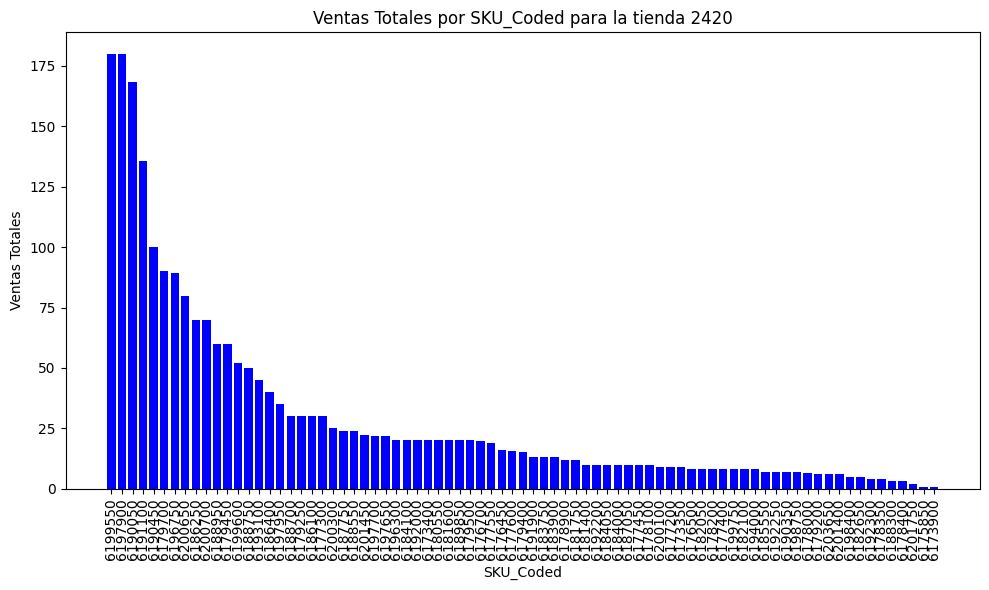

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import io

data = """SKU_Coded,Total_Sales
6192300,3.99
6192200,9.99
6200100,8.99
6178200,7.99
6183750,12.99
6186400,39.99
6179250,29.98
6200650,79.92
6181750,11.98
6179700,89.97
6191100,135.83
6177400,7.99
6188700,29.99
6203650,5.99
6188550,23.97
6173900,0.79
6184100,19.99
6193100,44.97
6201750,1.98
6192250,6.99
6175850,0.79
6188950,59.99
6182650,4.99
6176450,15.98
6177450,9.98
6182050,7.99
6188300,2.99
6197700,21.99
6179400,14.99
6190450,99.98
6187050,9.99
6192000,19.99
6177550,18.99
6199750,7.99
6177200,8.99
6191900,12.99
6184000,9.99
6173350,8.79
6180550,19.99
6182100,7.99
6183900,12.95
6198400,4.99
6196750,89.19
6178900,11.99
6184050,9.99
6173400,19.99
6179500,19.98
6178100,9.98
6197900,179.94
6196300,19.99
6187750,23.97
6185550,6.99
6199550,179.94
6190350,6.99
6177300,29.97
6177600,15.79
6189850,19.98
6197950,34.99
6201450,22.33
6186100,29.98
6197650,21.99
6176500,7.99
6194000,7.99
6186250,69.99
6178400,2.99
6200300,24.99
6201400,5.99
6181400,9.99
6200700,69.93
6199600,51.96
6179450,59.96
6181600,19.99
6190050,168.3
6179200,5.99
6176700,19.89
6198750,6.99
6178000,6.38
6178350,3.99
6188750,49.99"""

# Crear un DataFrame a partir de los datos
df = pd.read_csv(io.StringIO(data))

# Ordenar los datos por Total_Sales de mayor a menor
df_sorted = df.sort_values(by='Total_Sales', ascending=False)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.bar(df_sorted['SKU_Coded'].astype(str), df_sorted['Total_Sales'], color='blue')
plt.title('Ventas Totales por SKU_Coded para la tienda 2420')
plt.xlabel('SKU_Coded')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

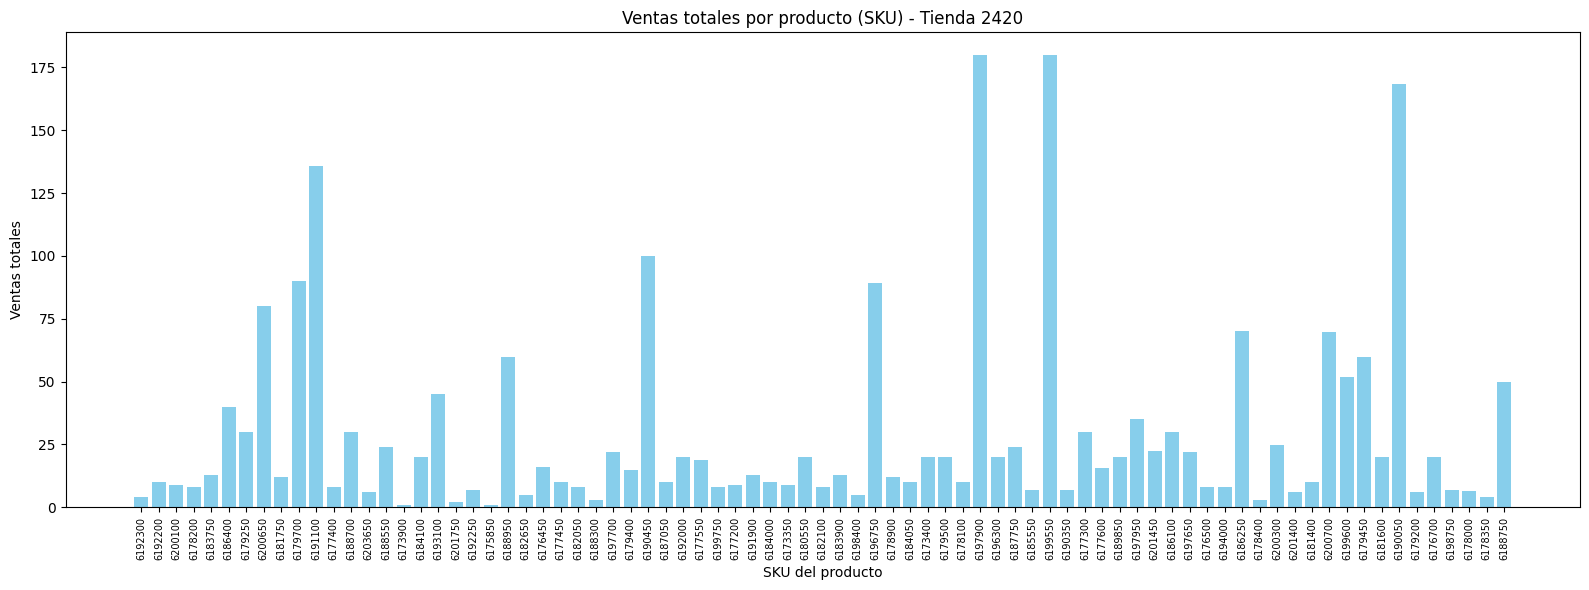

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos de ventas por producto para la tienda 2420
data = {
    'SKU_Coded': [
        6192300, 6192200, 6200100, 6178200, 6183750,
        6186400, 6179250, 6200650, 6181750, 6179700,
        6191100, 6177400, 6188700, 6203650, 6188550,
        6173900, 6184100, 6193100, 6201750, 6192250,
        6175850, 6188950, 6182650, 6176450, 6177450,
        6182050, 6188300, 6197700, 6179400, 6190450,
        6187050, 6192000, 6177550, 6199750, 6177200,
        6191900, 6184000, 6173350, 6180550, 6182100,
        6183900, 6198400, 6196750, 6178900, 6184050,
        6173400, 6179500, 6178100, 6197900, 6196300,
        6187750, 6185550, 6199550, 6190350, 6177300,
        6177600, 6189850, 6197950, 6201450, 6186100,
        6197650, 6176500, 6194000, 6186250, 6178400,
        6200300, 6201400, 6181400, 6200700, 6199600,
        6179450, 6181600, 6190050, 6179200, 6176700,
        6198750, 6178000, 6178350, 6188750
    ],
    'Total_Sale_Value': [
        3.99, 9.99, 8.99, 7.99, 12.99,
        39.99, 29.98, 79.92, 11.98, 89.97,
        135.83, 7.99, 29.99, 5.99, 23.97,
        0.79, 19.99, 44.97, 1.98, 6.99,
        0.79, 59.99, 4.99, 15.98, 9.98,
        7.99, 2.99, 21.99, 14.99, 99.98,
        9.99, 19.99, 18.99, 7.99, 8.99,
        12.99, 9.99, 8.79, 19.99, 7.99,
        12.95, 4.99, 89.19, 11.99, 9.99,
        19.99, 19.98, 9.98, 179.94, 19.99,
        23.97, 6.99, 179.94, 6.99, 29.97,
        15.79, 19.98, 34.99, 22.33, 29.98,
        21.99, 7.99, 7.99, 69.99, 2.99,
        24.99, 5.99, 9.99, 69.93, 51.96,
        59.96, 19.99, 168.3, 5.99, 19.89,
        6.99, 6.38, 3.99, 49.99
    ]
}

df = pd.DataFrame(data)

plt.figure(figsize=(16, 6))
plt.bar(df['SKU_Coded'].astype(str), df['Total_Sale_Value'], color='skyblue')
plt.title('Ventas totales por producto (SKU) - Tienda 2420')
plt.xlabel('SKU del producto')
plt.ylabel('Ventas totales')
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.show()

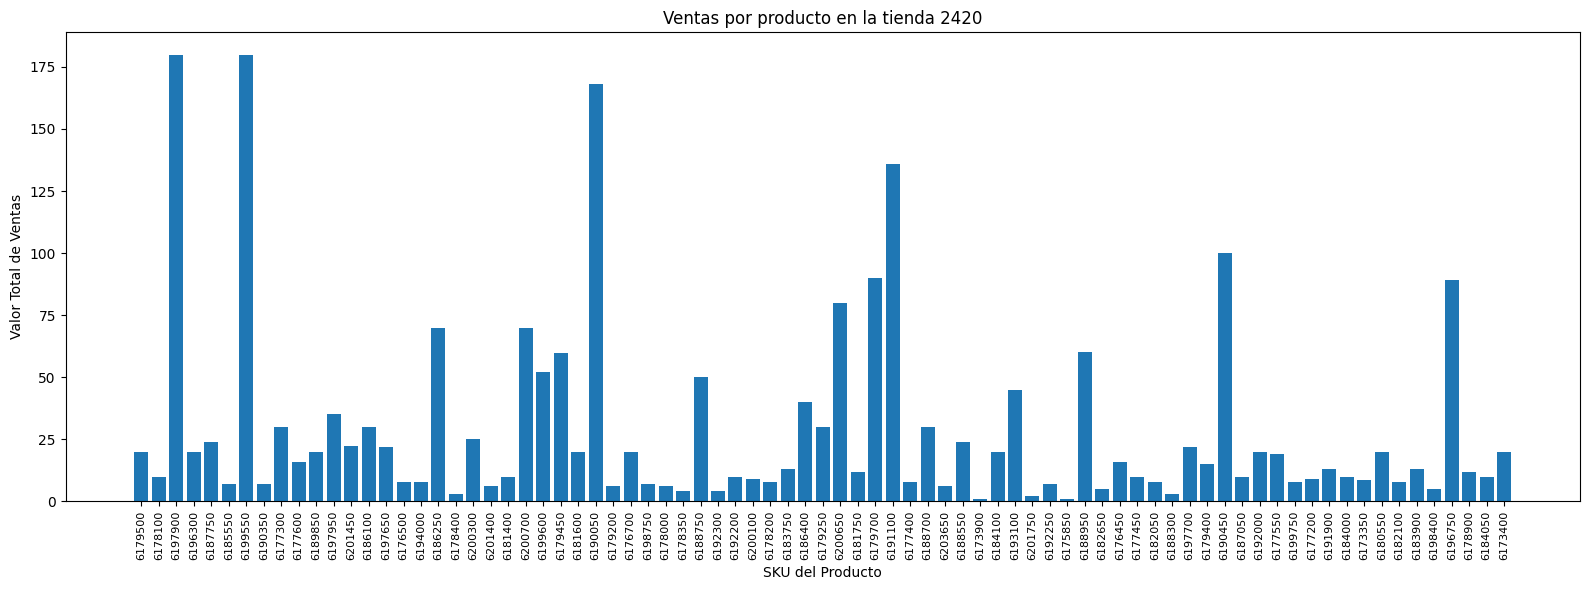

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos (puedes reemplazarlos leyendo desde tu archivo si lo prefieres)
data = {
    'SKU_Coded': [6179500, 6178100, 6197900, 6196300, 6187750, 6185550, 6199550, 6190350, 6177300,
                  6177600, 6189850, 6197950, 6201450, 6186100, 6197650, 6176500, 6194000, 6186250,
                  6178400, 6200300, 6201400, 6181400, 6200700, 6199600, 6179450, 6181600, 6190050,
                  6179200, 6176700, 6198750, 6178000, 6178350, 6188750, 6192300, 6192200, 6200100,
                  6178200, 6183750, 6186400, 6179250, 6200650, 6181750, 6179700, 6191100, 6177400,
                  6188700, 6203650, 6188550, 6173900, 6184100, 6193100, 6201750, 6192250, 6175850,
                  6188950, 6182650, 6176450, 6177450, 6182050, 6188300, 6197700, 6179400, 6190450,
                  6187050, 6192000, 6177550, 6199750, 6177200, 6191900, 6184000, 6173350, 6180550,
                  6182100, 6183900, 6198400, 6196750, 6178900, 6184050, 6173400],
    'Total_Sale_Value': [19.98, 9.98, 179.94, 19.99, 23.97, 6.99, 179.94, 6.99, 29.97,
                          15.79, 19.98, 34.99, 22.33, 29.98, 21.99, 7.99, 7.99, 69.99,
                          2.99, 24.99, 5.99, 9.99, 69.93, 51.96, 59.96, 19.99, 168.30,
                          5.99, 19.89, 6.99, 6.38, 3.99, 49.99, 3.99, 9.99, 8.99,
                          7.99, 12.99, 39.99, 29.98, 79.92, 11.98, 89.97, 135.83, 7.99,
                          29.99, 5.99, 23.97, 0.79, 19.99, 44.97, 1.98, 6.99, 0.79,
                          59.99, 4.99, 15.98, 9.98, 7.99, 2.99, 21.99, 14.99, 99.98,
                          9.99, 19.99, 18.99, 7.99, 8.99, 12.99, 9.99, 8.79, 19.99,
                          7.99, 12.95, 4.99, 89.19, 11.99, 9.99, 19.99]
}

df = pd.DataFrame(data)

plt.figure(figsize=(16, 6))
plt.bar(df['SKU_Coded'].astype(str), df['Total_Sale_Value'])
plt.title('Ventas por producto en la tienda 2420')
plt.xlabel('SKU del Producto')
plt.ylabel('Valor Total de Ventas')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

## Orquestador

Nuestro orquestador controlará la entrada y salida de información a nuestros subagentes de la misma manera que nuestros subagentes controlan la entrada y salida de información a nuestras herramientas. En realidad, nuestros subagentes se convierten en herramientas en el patrón orquestador-subagente. Para convertir agentes en herramientas, llamamos al método `as_tool` y proporcionamos un nombre y una descripción para nuestros agentes-como-herramientas.

Primero, definiremos las instrucciones para el orquestador, explicando su rol en nuestro sistema multi-agente:

In [ ]:
ORCHESTRATOR_PROMPT = (
    "Eres el orquestador de un sistema multi-agente. Tu tarea es tomar "
    "la consulta del usuario y pasarla al sub-agente/herramienta apropiado. Los sub-agentes "
    "verán la entrada que proporcionas y la utilizarán para obtener toda "
    "la información que necesitas para responder a la consulta del usuario. Es posible "
    "que necesites llamar a múltiples agentes para obtener toda la información que necesitas. "
    "No menciones ni llames la atención sobre el hecho de que este es un sistema multi-agente "
    "en tu conversación con el usuario. Ten en cuenta que eres un asistente de análisis de ventas para una empresa privada "
    "y si el usuario pregunta sobre información de la empresa "
    "o finanzas, debes utilizar nuestros datos internos en lugar de información pública."
    "Los subagentes no se ven entre ellos. Por lo cual, debes encargarte tu de que cuando se necesiten para trabajar, asegurar que se pueden comunicar y pasar la información correctamente".
)

Ahora definimos el orquestador, incluyendo nuestros subagentes usando el método `as_tool`:

In [ ]:
from datetime import datetime

@function_tool
def get_current_date():
    """Usa esta herramienta para obtener la fecha y hora actuales."""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

orchestrator = Agent(
    name="Orquestador",
    model="gpt-4.1",
    instructions=ORCHESTRATOR_PROMPT,
    tools=[
        data_lookup_agent.as_tool(
            tool_name="data_lookup_agent",  # no incluir espacios en el nombre de la herramienta
            tool_description="Buscar datos de ventas para obtener información actualizada"
        ),
        data_analysis_agent.as_tool(
            tool_name="data_analysis_agent",
            tool_description="Analizar datos de ventas para extraer insights"
        ),
        visualization_agent.as_tool(
            tool_name="visualization_agent",
            tool_description="Generar código para crear visualizaciones de datos"
        ),
        get_current_date,
    ],
)

Probemos nuestro agente con algunas consultas. Nuestra primera consulta requerirá que nuestro orquestador llame a múltiples herramientas.

In [ ]:
result = await Runner.run(
    starting_agent=orchestrator,
    #input="¿Cómo ha evolucionado la elasticidad de precios en los últimos meses? ¿Puedes mostrarme una visualización?"
    input="Create a bar chart showing total sales by store"
)
display(Markdown(result.final_output))

```sql
SELECT Store_Number, SUM(Total_Sale_Value) AS Total_Sales
FROM sales
GROUP BY Store_Number;
```


Aquí tienes el código para crear un gráfico de barras que muestra las ventas totales por tienda. Puedes copiar y ejecutar este código en tu entorno de Python para visualizar el gráfico:

```python
import matplotlib.pyplot as plt

# Datos de las tiendas y ventas
stores = ['550', '660', '770', '1760', '1980', '2420', '3190', '3410', '3630', '4180']
sales = [1524.47, 1762.88, 1674.66, 1716.33, 2301.54, 2304.86, 1866.23, 1867.96, 1732.27, 1825.20]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(stores, sales, color='skyblue')

# Etiquetas y título
plt.xlabel('Tienda')
plt.ylabel('Ventas Totales ($)')
plt.title('Ventas Totales por Tienda')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar gráfico
plt.tight_layout()
plt.show()
```

Si deseas los datos en otro formato o necesitas el gráfico como imagen, házmelo saber.

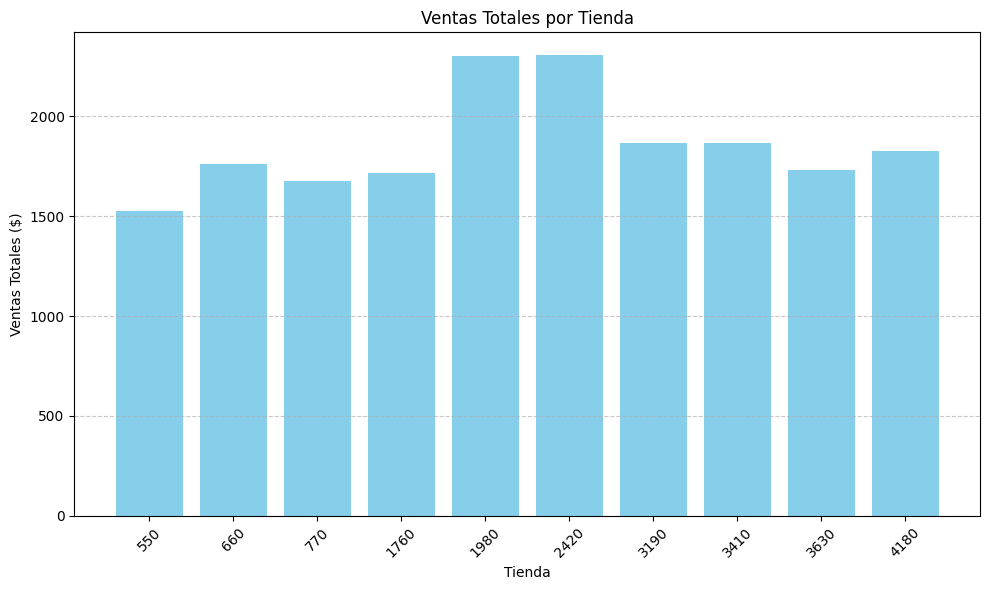

In [ ]:
import matplotlib.pyplot as plt

# Datos de las tiendas y ventas
stores = ['550', '660', '770', '1760', '1980', '2420', '3190', '3410', '3630', '4180']
sales = [1524.47, 1762.88, 1674.66, 1716.33, 2301.54, 2304.86, 1866.23, 1867.96, 1732.27, 1825.20]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(stores, sales, color='skyblue')

# Etiquetas y título
plt.xlabel('Tienda')
plt.ylabel('Ventas Totales ($)')
plt.title('Ventas Totales por Tienda')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar gráfico
plt.tight_layout()
plt.show()


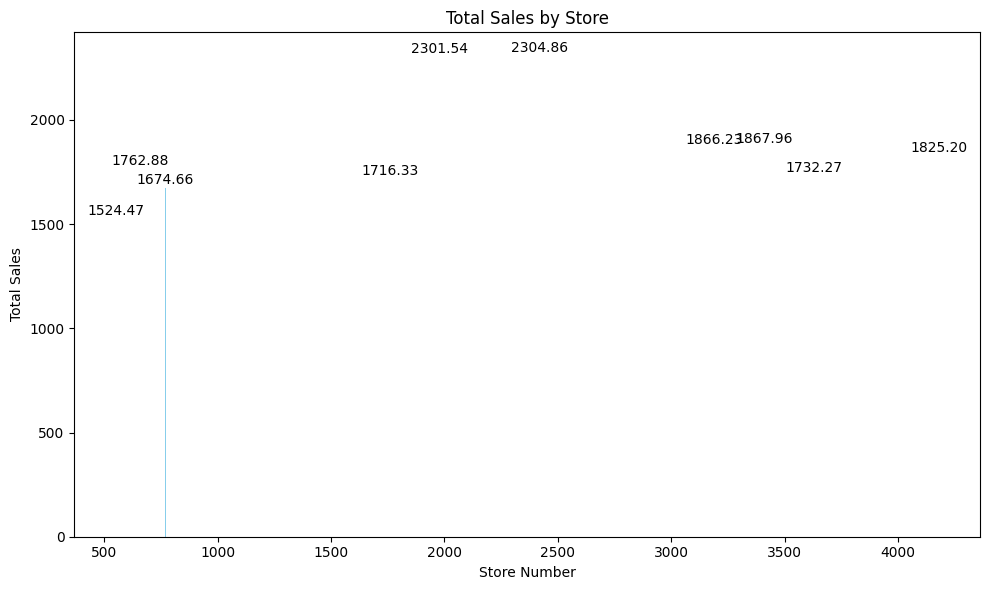

In [ ]:
import matplotlib.pyplot as plt

# Store numbers and corresponding total sales
store_numbers = [550, 660, 770, 1760, 1980, 2420, 3190, 3410, 3630, 4180]
total_sales = [1524.47, 1762.88, 1674.66, 1716.33, 2301.54, 2304.86, 1866.23, 1867.96, 1732.27, 1825.20]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(store_numbers, total_sales, color='skyblue')

# Add titles and labels
plt.title("Total Sales by Store")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")

# Show values on top of each bar for clarity
for i, v in enumerate(total_sales):
    plt.text(store_numbers[i], v + 20, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

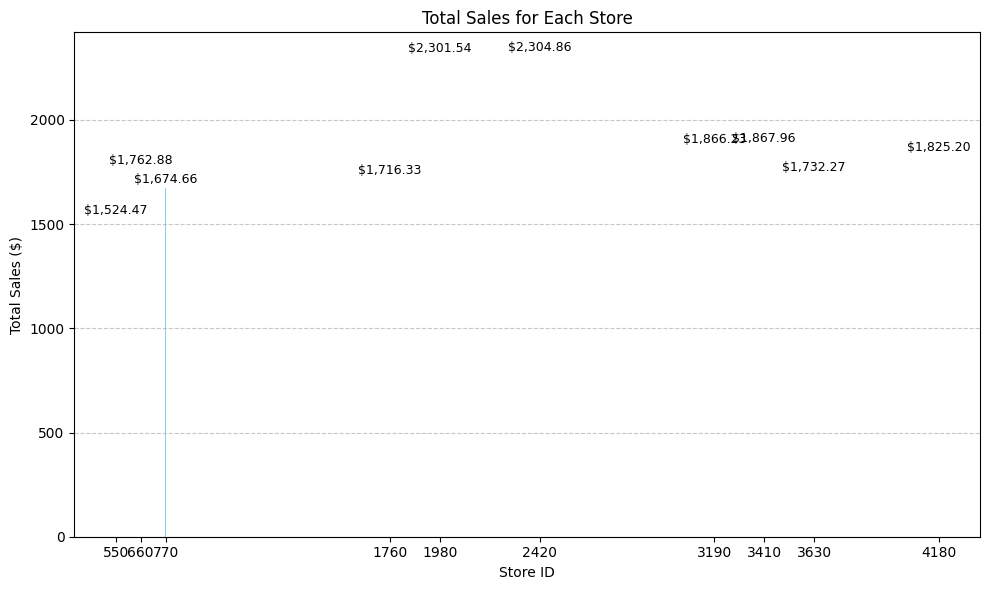

In [ ]:
import matplotlib.pyplot as plt

# Store IDs and their corresponding total sales
stores = [550, 660, 770, 1760, 1980, 2420, 3190, 3410, 3630, 4180]
sales = [1524.47, 1762.88, 1674.66, 1716.33, 2301.54, 2304.86, 1866.23, 1867.96, 1732.27, 1825.20]

plt.figure(figsize=(10,6))
bars = plt.bar(stores, sales, color='skyblue')

plt.xlabel('Store ID')
plt.ylabel('Total Sales ($)')
plt.title('Total Sales for Each Store')
plt.xticks(stores)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+10,
             f'${bar.get_height():,.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

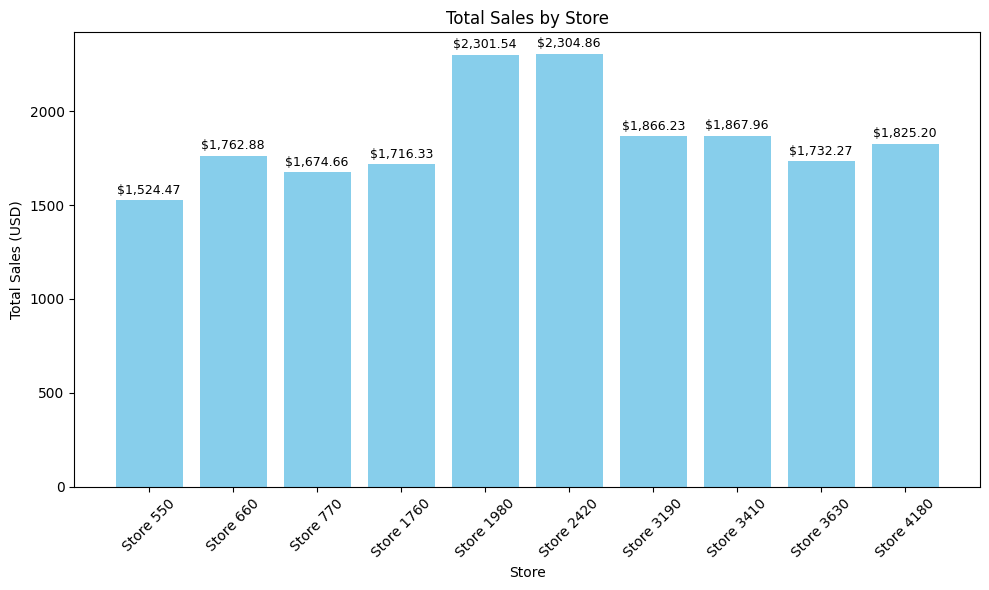

In [ ]:
import matplotlib.pyplot as plt

# Data
stores = [
    'Store 550', 'Store 660', 'Store 770', 'Store 1760', 'Store 1980',
    'Store 2420', 'Store 3190', 'Store 3410', 'Store 3630', 'Store 4180'
]
sales = [
    1524.47, 1762.88, 1674.66, 1716.33, 2301.54,
    2304.86, 1866.23, 1867.96, 1732.27, 1825.20
]

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(stores, sales, color='skyblue')
plt.xlabel('Store')
plt.ylabel('Total Sales (USD)')
plt.title('Total Sales by Store')
plt.xticks(rotation=45)
plt.tight_layout()

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, yval + 20,  # 20 for spacing above bar
        f"${yval:,.2f}", ha='center', va='bottom', fontsize=9
    )

plt.show()


Hagamos otra pregunta:

In [ ]:
result = await Runner.run(
    starting_agent=orchestrator,
    input="What was the most popular product SKU?"
    #input=(
    #    "¿Cuáles son las 3 promociones más efectivas en términos de incremento de ventas "
    #    "y qué porcentaje de las ventas totales representan?"
    #)
)
display(Markdown(result.final_output))

```sql
SELECT SKU_Coded, SUM(Qty_Sold) as total_sales FROM sales GROUP BY SKU_Coded ORDER BY total_sales DESC LIMIT 1
```


The most popular product SKU is 6190050, with a total sales volume of 179 units.

In [ ]:
result = await Runner.run(
    starting_agent=orchestrator,
    input="What was the most popular product SKU?"
    #input=(
    #    "¿Cuáles son las 3 promociones más efectivas en términos de incremento de ventas "
    #    "y qué porcentaje de las ventas totales representan?"
    #)
)
display(Markdown(result.final_output))

```sql
SELECT SKU_Coded, SUM(Qty_Sold) AS Total_Qty_Sold
FROM sales
GROUP BY SKU_Coded
ORDER BY Total_Qty_Sold DESC
LIMIT 1;
```


The most popular product SKU is 6190050, with a total of 179 units sold.

Nuestro flujo de trabajo orquestador-subagente está funcionando bien. El orquestador coordina eficientemente los diferentes subagentes especializados, permitiéndonos analizar datos de ventas, realizar análisis y crear visualizaciones, todo dentro de un sistema integrado.

# **Ejercicio**:

Dada la siguiente traza, ¿podrías describir cuál es el problema y cómo solucionarlo?

<img src="https://ikasten.io/images/bug_agente.png">

**Ejercicio**:

Dada la siguiente traza, ¿podrías describir cuál es el problema y cómo solucionarlo?

_Prompt_: "Usando tus herramientas especializadas crea una visualización que muestre la evolución de las ventas de la tienda 2420 a lo largo del tiempo"

<img src="https://ikasten.io/images/bug_agentes_3.png">
<img src="https://ikasten.io/images/bug_agentes_2.png">

## Conclusión

En este tutorial, hemos aprendido cómo crear un sistema multi-agente utilizando el SDK de Agentes de OpenAI con un patrón orquestador-subagente. Este enfoque nos permite descomponer tareas complejas en componentes más manejables, donde cada subagente se especializa en un aspecto particular del análisis de datos de ventas:

1. **Subagente de Consulta de Datos**: Maneja la recuperación de datos específicos del conjunto de datos de ventas.
2. **Subagente de Análisis de Datos**: Proporciona análisis e insights basados en los datos recuperados.
3. **Subagente de Visualización**: Crea visualizaciones para ayudar a entender mejor los datos.

El orquestador coordina estos subagentes, dirigiendo las consultas del usuario al subagente adecuado y recopilando sus respuestas para proporcionar una respuesta completa y coherente.

Este enfoque puede aplicarse a una gran variedad de casos de uso donde se requiere un procesamiento complejo de datos y un análisis profundo (en cualquier dominio donde la inteligencia artificial pueda proporcionar valor a través de la orquestación de múltiples agentes especializados).